# 3. Frame Selection Process

In [2]:
from src import *

In [3]:
import pygmo as pg

## Description

We look in this section for the stability of frame selected gradients across subjects (individual gradients approach) and also how stable the group gradients are when frame selecting compared to when full is used. 

GOAL: Evaluate differences of individual gradients of selected gradients and movie long gradients + evaluate differences of group gradients of selected timeseries and group gradients of full movies 

## Table of Contents
<!-- - [Frame selected (by discrete emotion timecourses) series](#discreteemo) -->
- [3FA timecourses visualization](#3fa_viz)
- [Frame selected (by 3FA timecourses) series](#3fa)
- [Frame selected (by combination 3FA timecourses) series](#comb3fa)
<!-- - [Frame selected (by pareto 3FA timecourses) series](#pareto3fa) -->

In [4]:
# In-Tervals percentages (non overlap)
# s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
thresholds = s25

In [5]:
def compute_mask_percentile(series, lb, rb):
    """
        Compute Mask for a 1d series (mostly) with left bound (lb)
        and right bound (rb) in percentile format
        
        
        lb::[int] percentile
        rb::[int] percentile
    """
    
    eval_lb = np.percentile(series, lb)
    eval_rb = np.percentile(series, rb)
    ret = (series >= eval_lb) & (series <= eval_rb)
    return ret


def find_boundcontinuous(m):
    """
        Return pairs of bounds corresponding to the 
        percentiles of the timecourse value we want
        
        m::[1darray] timecourse
    """
    
    P = []
    cur_start = 0
    prev_val = m[0]
    for k in range(1,len(m)):
        cur_val = m[k]
        if prev_val and cur_val:
            continue
        if prev_val and (not cur_val):
            P.append((cur_start,k-1))
            cur_start = k
        if (not prev_val) and cur_val:
            cur_start = k

        prev_val = cur_val
    
    if cur_val and cur_start != k:
        P.append((cur_start, k))
    return P

def percentile2coord(tup, S):
    """ 
    quick transpose of percentile values to coordinates in matrix
    """
    a = S.index((tup[0],tup[1]))
    b = S.index((tup[2],tup[3]))
    return a,b

Keeping movies only frames (removing washer and shifting by onsets of BOLD)

In [4]:
onsets = load('./data/run_onsets.pkl')

mri_path400 = "./data/fmri414_compiled/"

total_series = {m.split('_')[0]:{} for m in os.listdir(mri_path400)}

for movie_name400 in tqdm(os.listdir(mri_path400)):
    if "Rest" in movie_name400: continue        
    mri_df400mov  = pd.read_csv(mri_path400 + movie_name400)
    mname         = movie_name400.split('_')[0]

    # film_duration = FILM2DURATION[mname] # in seconds
    # duration_film = int(film_duration/ TR) # in number of TRs
    # front_pad     = int(WASH + ONSET) + 1

    # Simply replace 400 by 414 to look at spatial relation with subcortical regions included
    subject_names = [m for m in mri_df400mov.filename.unique() if "414" in m] 
    movie_series = []
    for m in subject_names:
        
        subject_id = m[11:14]
        if mname == 'BetweenViewing':
            front_pad, duration_film = onsets[mname+'s'][subject_id]
        else:
            front_pad, duration_film = onsets[mname][subject_id]
            
        tmp1, _  = df_to_timeseries(mri_df400mov, m)
        tmp1     = tmp1[front_pad :  front_pad + duration_film]
        
        total_series[mname][subject_id] = tmp1

save('./data/fmri_414_series.pkl', total_series)

<a class="anchor" id="3fa_viz"></a>
## 3FA timecourses visualization

In [29]:
filmnames = list(FILM2DURATION.keys())

In [30]:
import csv

fa_timecourse = {}
for fname in filmnames:
    with open("./data/emo3FA/3FA_13_{}_stim.tsv".format(fname)) as file:
        tsv_file = csv.reader(file, delimiter="\t")
        fa_timecourse[fname] = np.array(list(tsv_file), dtype=float)

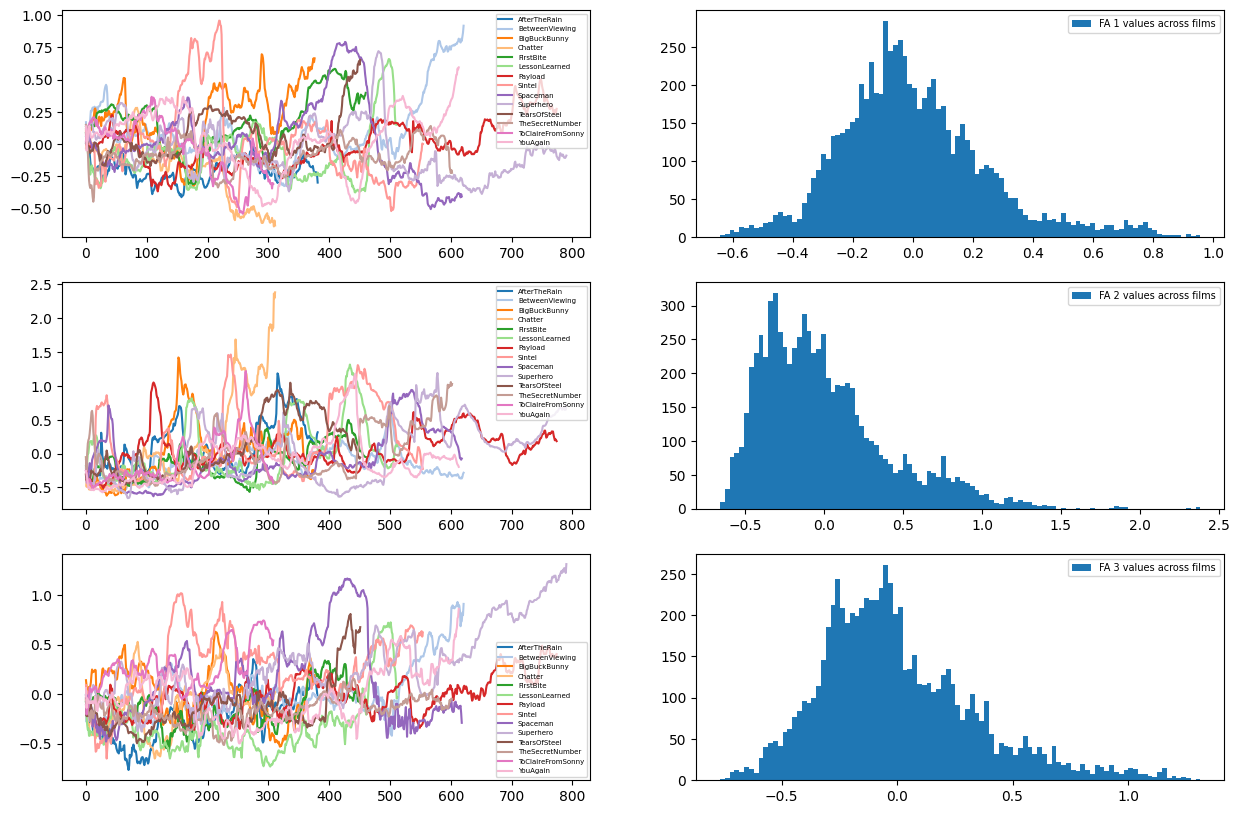

In [31]:
from matplotlib.colors import ListedColormap
# Displaying
pal     = sns.color_palette('tab20', len(fa_timecourse))
my_cmap = ListedColormap(pal)
fig, ax = plt.subplots(3,2,figsize=(15,10))

fa_thresh = {}
for k in range(3): # number of factors: 
    for idx,moviename in enumerate(fa_timecourse):
        ax[k,0].plot(fa_timecourse[moviename][:,k], label=moviename, color=my_cmap.colors[idx])
    ax[k,0].legend(prop={'size':5})

    distrib = np.concatenate(list(fa_timecourse.values()))[:,k]
    
    fa_thresh[k] = distrib
    ax[k,1].hist(distrib, bins=100, label='FA {} values across films'.format(k+1))
    ax[k,1].legend(prop={'size':7})

<a class="anchor" id="3fa"></a>
## Frame selected (by 3FA timecourses) series

In [32]:
total_series = load('./data/fmri_414_series.pkl')

threshed_series = {}

# Frame select on emotions
for k in range(3): #for the 3 factors in FA
    # obtain threshed series for each "emotion intensity computation"
    per_score = {}
    
    thresholds_util = fa_thresh[k]
    for t in tqdm(range(len(thresholds))):
        # obtain threshed series for each "threshold"
        lb,rb = thresholds[t]
        lval, rval = np.percentile(thresholds_util, lb), np.percentile(thresholds_util, rb)
        per_threshold = {}
        
        for mname in total_series.keys():
            # obtain threshed series for each "movie"
            if mname == 'Rest': continue
            movie_series = total_series[mname]
#             mask = compute_mask_percentile(fa_timecourse[mname][:size,k], lb, rb) # take k-th factors
            per_movie = {}
            for _id in movie_series:
                size = movie_series[_id].shape[0]
                mask =  (lval <= fa_timecourse[mname][:size,k]) & (fa_timecourse[mname][:size,k] <= rval)            
                # obtain threshed series for each "id"
                per_movie[_id] = movie_series[_id][mask]
            
            per_threshold[mname] = per_movie
        per_score[(lb,rb)] = per_threshold
    threshed_series[k] = per_score

save('./resources/threshed_series/fa_global_treshed_series.pkl', threshed_series)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

#### Visualizing the frame selected per percentiles (e.g scoring 2 in emotion timecourse) 
Also a quick snippet of the corresponding time series

In [33]:
total_series = load('./data/fmri_414_series.pkl')
del total_series['Rest']

/tmp/ipykernel_150601/3700872074.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(100*np.arange(-1,6), fontsize=16)
/tmp/ipykernel_150601/3700872074.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(100*np.arange(-1,6), fontsize=16)


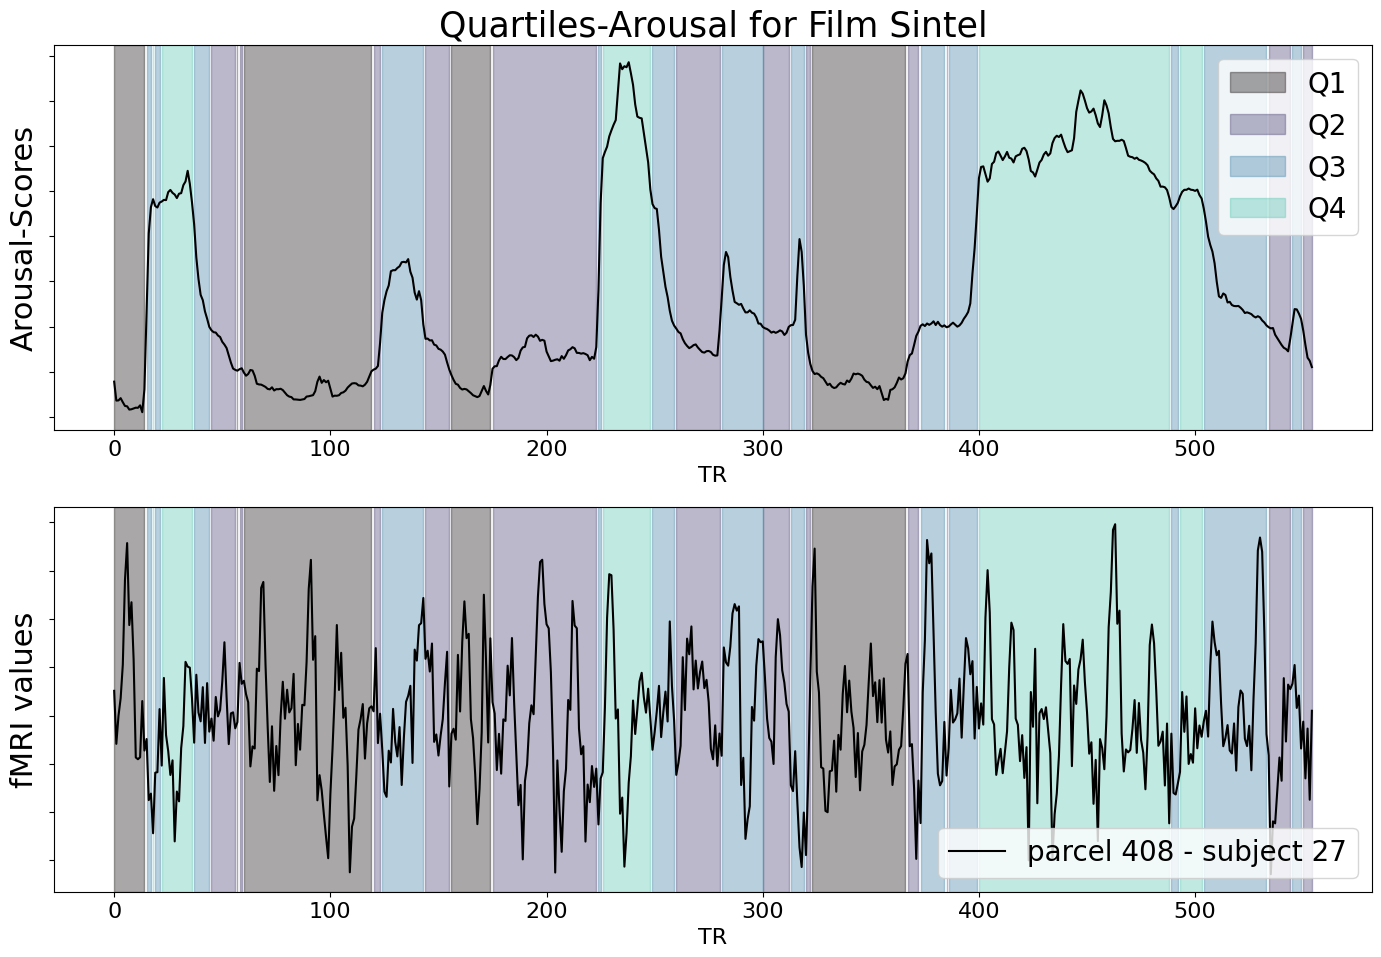

In [34]:
from matplotlib.pyplot import cm

fa_idx = 1
mname = 'Sintel'
title = "25%"
bounds = np.array(s25)
fig, ax = plt.subplots(2,figsize=(17,11))

# 1. Plot the 3FA scores guiding frame selection
color = plt.get_cmap('mako')(np.linspace(0, 1, len(bounds)+1))
for bdx,b in enumerate(bounds):
    lb,rb = b
    if bdx == 0:
        ax[0].plot(fa_timecourse[mname][:,fa_idx], color='k')

    mask = compute_mask_percentile(fa_timecourse[mname][:,fa_idx], lb, rb)
    pairs = find_boundcontinuous(mask)
    for pidx, pair in enumerate(pairs):
        if pidx == 0:
            ax[0].axvspan(pair[0], pair[1], alpha=.35, color=color[bdx], label='Q{}'.format(bdx+1))
        else:
            ax[0].axvspan(pair[0], pair[1], alpha=.35, color=color[bdx])
            
ax[0].legend(prop={'size':20})
ax[0].set_xlabel('TR', fontsize=16)
ax[0].set_ylabel('Arousal-Scores', fontsize=22)
ax[0].set_yticklabels([])
ax[0].set_xticklabels(100*np.arange(-1,6), fontsize=16)
ax[0].set_title('Quartiles-Arousal for Film {}'.format(mname), fontsize=25)

# 2. Plot corresponding fMRI frames
ax[1].plot(total_series['Sintel']['S27'][:,408], label='parcel 408 - subject 27', color='k')
ax[1].legend(prop={'size':20})
ax[1].set_xlabel('TR', fontsize=16)
ax[1].set_ylabel('fMRI values', fontsize=22)
ax[1].set_yticklabels([])
ax[1].set_xticklabels(100*np.arange(-1,6), fontsize=16)

for bdx,b in enumerate(bounds):
    lb,rb = b

    mask = compute_mask_percentile(fa_timecourse[mname][:,fa_idx], lb, rb)
    pairs = find_boundcontinuous(mask)
    for pidx, pair in enumerate(pairs):
        if pidx == 0:
            ax[1].axvspan(pair[0], pair[1], alpha=.35, color=color[bdx], label='Q{}'.format(pidx))
        else:
            ax[1].axvspan(pair[0], pair[1], alpha=.35, color=color[bdx])

Plot of summary figure (schematic description)

/tmp/ipykernel_150601/3815155936.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(100*np.arange(-1,6), fontsize=16)
/tmp/ipykernel_150601/3815155936.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(100*np.arange(-1,6), fontsize=16)


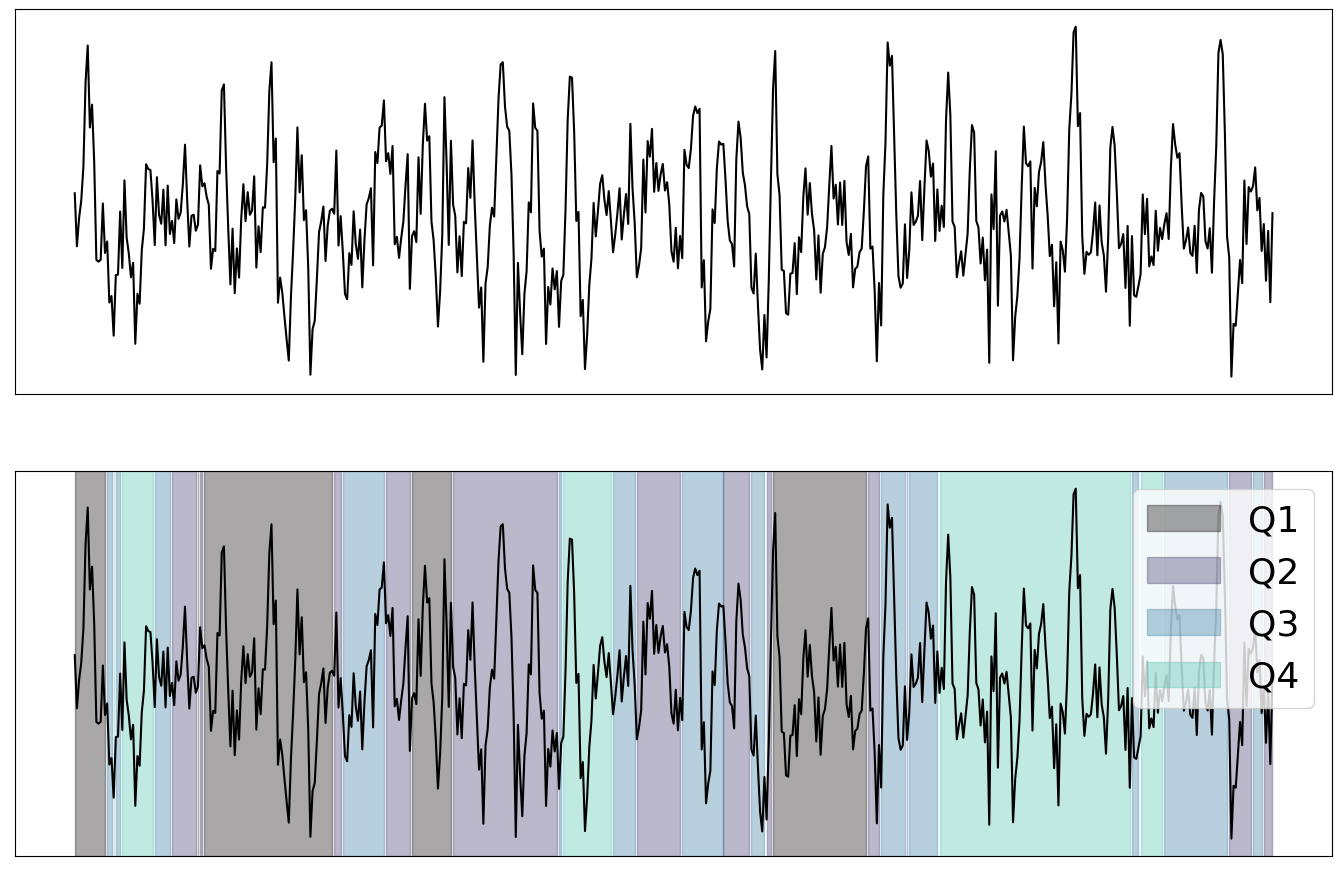

In [35]:
fa_idx = 1
bounds = np.array(s25)
fig, ax = plt.subplots(2,figsize=(17,11))

color = plt.get_cmap('mako')(np.linspace(0, 1, len(bounds)+1))
ax[0].plot(total_series['Sintel']['S27'][:,408], color='k')

ax[0].set_yticklabels([])
ax[0].set_xticklabels(100*np.arange(-1,6), fontsize=16)
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].plot(total_series['Sintel']['S27'][:,408], color='k')
ax[1].set_yticklabels([])
ax[1].set_xticklabels(100*np.arange(-1,6), fontsize=16)

for bdx,b in enumerate(bounds):
    lb,rb = b

    mask = compute_mask_percentile(fa_timecourse[mname][:,fa_idx], lb, rb)
    pairs = find_boundcontinuous(mask)
    for pidx, pair in enumerate(pairs):
        if pidx == 0:
            ax[1].axvspan(pair[0], pair[1], alpha=.35, color=color[bdx], label='Q{}'.format(bdx + 1))
        else:
            ax[1].axvspan(pair[0], pair[1], alpha=.35, color=color[bdx])

ax[1].legend(prop={'size':26})
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

<a class="anchor" id="comb3fa"></a>
## Frame selected (by combination 3FA timecourses) series

In [36]:
total_series = load('./data/fmri_414_series.pkl')

threshed_series = {}

# Frame select on emotions
per_score = {}

# choice of cross fa global (in this order valence/arousal or valence/power or arousal/power)
thresholds_util1 = fa_thresh[1]
thresholds_util2 = fa_thresh[2]
for t1 in tqdm(range(len(thresholds))):
    # obtain threshed series for each "threshold"
    lb1,rb1 = thresholds[t1]
    for t2 in range(len(thresholds)):
        lb2,rb2 = thresholds[t2]
        lval1, rval1 = np.percentile(thresholds_util1, lb1), np.percentile(thresholds_util1, rb1)
        lval2, rval2 = np.percentile(thresholds_util2, lb2), np.percentile(thresholds_util2, rb2)    

        per_threshold = {}

        for mname in total_series.keys():
            # obtain threshed series for each "movie"
            if mname == 'Rest': continue
            movie_series = total_series[mname]
    #             mask = compute_mask_percentile(fa_timecourse[mname][:size,k], lb, rb) # take k-th factors
            per_movie = {}
            for _id in movie_series:
                size = movie_series[_id].shape[0]
                mask1 =  (lval1 <= fa_timecourse[mname][:size,0]) & (fa_timecourse[mname][:size,0] <= rval1)
                mask2 =  (lval2 <= fa_timecourse[mname][:size,1]) & (fa_timecourse[mname][:size,1] <= rval2)        

                mask = (mask1) & (mask2)
                # obtain threshed series for each "id"
                per_movie[_id] = movie_series[_id][mask]

            per_threshold[mname] = per_movie
        per_score[(lb1,rb1,lb2,rb2)] = per_threshold
    
save('./resources/threshed_series/fa_global_cross_tseries_aro-pow_bin25.pkl', per_score)

  0%|          | 0/4 [00:00<?, ?it/s]

#### Look at length of each intersection of percentiles

In [6]:
threshed_series1 = {0:load('./resources/threshed_series/fa_global_cross_tseries_val-aro_bin25.pkl')}
threshed_series2 = {0:load('./resources/threshed_series/fa_global_cross_tseries_val-pow_bin25.pkl')}
threshed_series3 = {0:load('./resources/threshed_series/fa_global_cross_tseries_aro-pow_bin25.pkl')}

total_series = load('./data/fmri_414_series.pkl')

In [7]:
B = deepcopy(s25)

length_grid1 = np.zeros((len(B), len(B)))
for bound in threshed_series1[0]:
    x,y = percentile2coord(bound, B)
    length_grid1[x,y] = 0
    for mname in threshed_series1[0][bound]:
        # any individuals taken is fine
        length_grid1[x,y] += len(threshed_series1[0][bound][mname]['S27'])
        
length_grid2 = np.zeros((len(B), len(B)))
for bound in threshed_series2[0]:
    x,y = percentile2coord(bound, B)
    length_grid2[x,y] = 0
    for mname in threshed_series2[0][bound]:
        # any individuals taken is fine
        length_grid2[x,y] += len(threshed_series2[0][bound][mname]['S27'])
        
length_grid3 = np.zeros((len(B), len(B)))
for bound in threshed_series3[0]:
    x,y = percentile2coord(bound, B)
    length_grid3[x,y] = 0
    for mname in threshed_series3[0][bound]:
        # any individuals taken is fine
        length_grid3[x,y] += len(threshed_series3[0][bound][mname]['S27'])

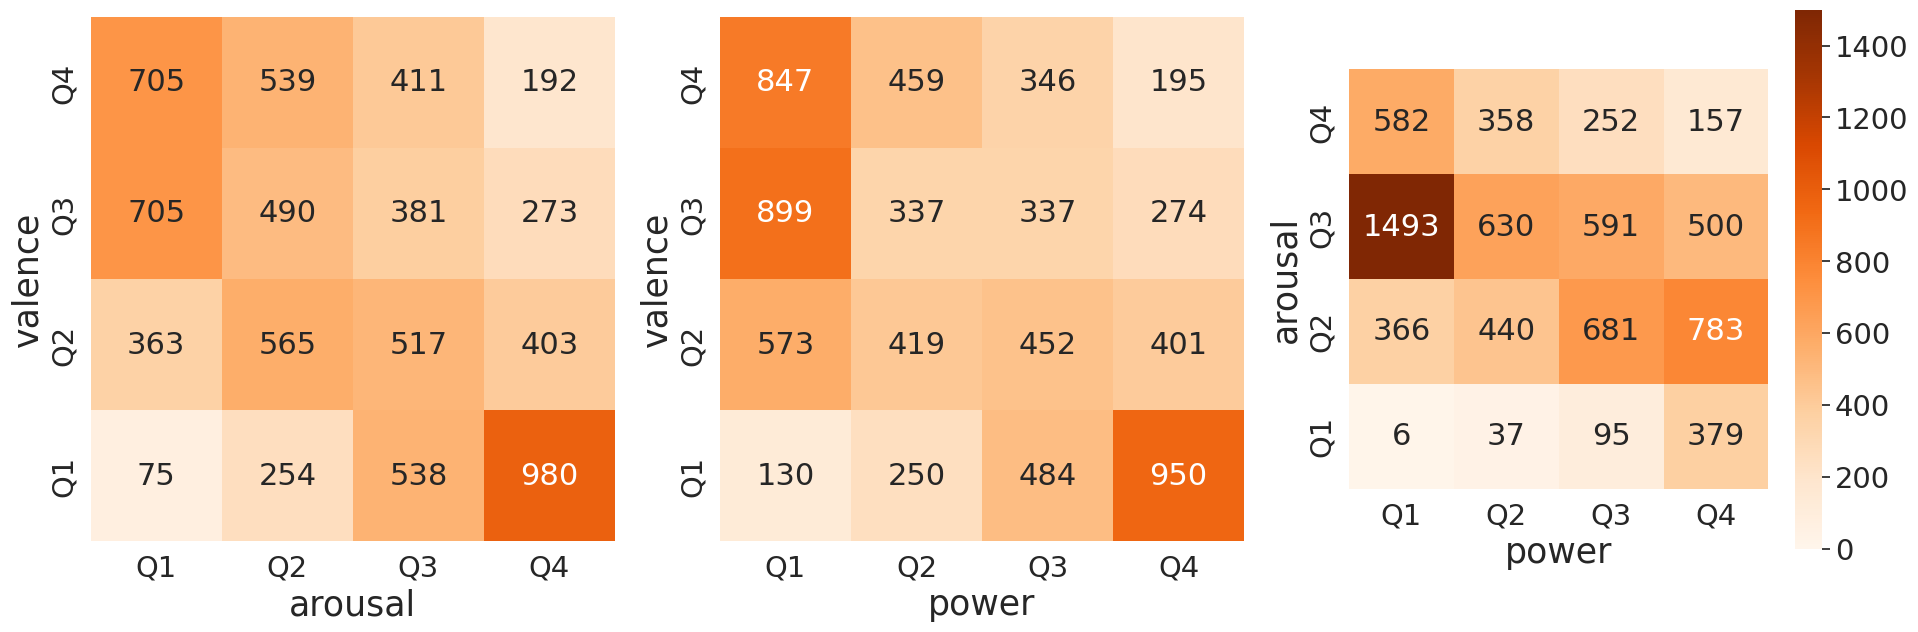

In [8]:
import matplotlib.colors as mcolors

norm = mcolors.Normalize(0, 1500)

tickslabels = ['Q1', 'Q2', 'Q3','Q4']

import seaborn as sns
sns.set(font_scale=1.9)

fig, ax = plt.subplots(1,3, figsize=(23,7))
sns.heatmap(length_grid1[::-1], annot=True, xticklabels=tickslabels, yticklabels=tickslabels[::-1], 
            ax=ax[0],cmap='Oranges',fmt='.0f', annot_kws={"size":22}, norm=norm,  cbar=False,
           square=True)
sns.heatmap(length_grid2[::-1], annot=True, xticklabels=tickslabels, yticklabels=tickslabels[::-1], 
            ax=ax[1],cmap='Oranges',fmt='.0f', annot_kws={"size":22}, norm=norm,  cbar=False,
           square=True)
sns.heatmap(length_grid3[::-1], annot=True, xticklabels=tickslabels, yticklabels=tickslabels[::-1], 
            ax=ax[2],cmap='Oranges',fmt='.0f', annot_kws={"size":22}, norm=norm,  cbar=True,
           square=True)

labels = [('valence', 'arousal'), ('valence','power'), ('arousal','power')]
titlelabels = ['V/A', 'V/P', 'A/P']

for k in range(3):
    ax[k].set_xlabel(labels[k][1], fontsize=25)
    ax[k].set_ylabel(labels[k][0], fontsize=25)
#     ax[k].set_title('Nb of Frames Intersect {}'.format(titlelabels[k]), fontsize=25)

#### Generate Individual Random selected Frames

In [43]:
# switch bounds and mname in dictionary
iter_series1 = {mname: {} for mname in threshed_series1[0][(0,25,0,25)]}
for bounds in threshed_series1[0]:
    tmp = threshed_series1[0][bounds]
    for mname in tmp:
        iter_series1[mname][bounds] = tmp[mname]
        
iter_series2 = {mname: {} for mname in threshed_series2[0][(0,25,0,25)]}
for bounds in threshed_series2[0]:
    tmp = threshed_series2[0][bounds]
    for mname in tmp:
        iter_series2[mname][bounds] = tmp[mname]
        
iter_series3 = {mname: {} for mname in threshed_series3[0][(0,25,0,25)]}
for bounds in threshed_series3[0]:
    tmp = threshed_series3[0][bounds]
    for mname in tmp:
        iter_series3[mname][bounds] = tmp[mname]

seeds (54,69,79,89,99)

In [ ]:
order_bounds = list(iter_series1['Sintel'].keys())
subjects = list(iter_series1['Sintel'][(0,25,0,25)].keys())

null_iter = 50

random_series1 = {bound: {mname: {_id: [] for _id in subjects} for mname in threshed_series1[0][bound]}
                  for bound in threshed_series1[0]}
random_series2 = {bound: {mname: {_id: [] for _id in subjects} for mname in threshed_series2[0][bound]}
                  for bound in threshed_series2[0]}
random_series3 = {bound: {mname: {_id: [] for _id in subjects} for mname in threshed_series3[0][bound]}
                  for bound in threshed_series3[0]}
np.random.seed(99)
# Iterate over the different bounds for the three cross Val/Aro/Pow
for mname in tqdm(iter_series1):
    per_boundlength1 = []
    per_boundlength2 = []
    per_boundlength3 = []
    
    for bound in order_bounds:
        per_boundlength1.append(np.min([len(threshed_series1[0][bound][mname][_id]) for _id in subjects]))
        per_boundlength2.append(np.min([len(threshed_series2[0][bound][mname][_id]) for _id in subjects]))
        per_boundlength3.append(np.min([len(threshed_series3[0][bound][mname][_id]) for _id in subjects]))
        
#         per_boundlength1.append(len(threshed_series1[0][bound][mname]['S27']))
#         per_boundlength2.append(len(threshed_series2[0][bound][mname]['S27']))
#         per_boundlength3.append(len(threshed_series3[0][bound][mname]['S27']))
    
    length_series = np.min([len(total_series[mname][_id]) for _id in subjects])
    order = np.arange(length_series)

    # partition sequentially many times
    for repeat in range(null_iter):
        shuffle_order = np.random.permutation(order)
        partitions1 = np.split(shuffle_order, np.cumsum(per_boundlength1)[:-1])
        partitions2 = np.split(shuffle_order, np.cumsum(per_boundlength2)[:-1])
        partitions3 = np.split(shuffle_order, np.cumsum(per_boundlength3)[:-1])
        
        for bidx, bound in enumerate(order_bounds):
            for _id in subjects:
                random_series1[bound][mname][_id].append(total_series[mname][_id][partitions1[bidx]])
                random_series2[bound][mname][_id].append(total_series[mname][_id][partitions2[bidx]])
                random_series3[bound][mname][_id].append(total_series[mname][_id][partitions3[bidx]])

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
save('./resources/threshed_series/null_seriescube/rs1_50-5.pkl', random_series1)
save('./resources/threshed_series/null_seriescube/rs2_50-5.pkl', random_series2)
save('./resources/threshed_series/null_seriescube/rs3_50-5.pkl', random_series3)